In [1]:


!pip install ultralytics
!pip install shapely

#install important packages


[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from ultralytics import YOLO

from matplotlib.pyplot import figure
import matplotlib.image as image
from matplotlib import pyplot as plt


import pandas as pd
import numpy as np
from numpy import asarray
from PIL import Image

import cv2

from shapely.geometry import Polygon


In [3]:
# calculates iou between two polygons

def calculate_iou(box_1, box_2):
    poly_1 = Polygon(box_1)
    poly_2 = Polygon(box_2)
    iou = poly_1.intersection(poly_2).area / poly_1.union(poly_2).area
    return iou

In [4]:


def detect_corners(image_path):
    # Load YOLO model trained to detect corners on a chessboard
    model_trained = YOLO("best.pt")
    
    # Predict corners on the image
    results = model_trained.predict(source=image_path, line_thickness=1, conf=0.25, save_txt=True, save=True)
    
    # Ensure results are not empty and extract box coordinates
    if results:
        boxes = results[0].boxes
        arr = boxes.xywh.numpy()
        points = arr[:, 0:2]
        
        # Order the points if the function is defined
        corners = order_points(points)
        print(corners)
        return corners 
    else:
        print("No corners detected.")
        return None

def order_points(pts):
    """
    Order the points in a consistent order.
    This example assumes a simple rectangular object.
    """
    rect = np.zeros((4, 2), dtype="float32")
    
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    
    return rect



In [5]:
# perspective transforms an image with four given corners

def four_point_transform(image, pts):
      
    img = Image.open(image)
    image = asarray(img)
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    # compute the width of the new image
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
   

    # compute the height of the new image
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    # construct set of destination points to obtain a "birds eye view"
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")

    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    
    img = Image.fromarray(warped, "RGB")
    img.show()
    return img

In [6]:
# calculates chessboard grid

def plot_grid_on_transformed_image(image):
    
    corners = np.array([[0,0], 
                    [image.size[0], 0], 
                    [0, image.size[1]], 
                    [image.size[0], image.size[1]]])
    
    corners = order_points(corners)

    figure(figsize=(10, 10), dpi=80)

    # im = plt.imread(image)
    implot = plt.imshow(image)
    
    TL = corners[0]
    BL = corners[3]
    TR = corners[1]
    BR = corners[2]

    def interpolate(xy0, xy1):
        x0,y0 = xy0
        x1,y1 = xy1
        dx = (x1-x0) / 8
        dy = (y1-y0) / 8
        pts = [(x0+i*dx,y0+i*dy) for i in range(9)]
        return pts

    ptsT = interpolate( TL, TR )
    ptsL = interpolate( TL, BL )
    ptsR = interpolate( TR, BR )
    ptsB = interpolate( BL, BR )
        
    for a,b in zip(ptsL, ptsR):
        plt.plot( [a[0], b[0]], [a[1], b[1]], 'ro', linestyle="--" )
    for a,b in zip(ptsT, ptsB):
        plt.plot( [a[0], b[0]], [a[1], b[1]], 'ro', linestyle="--" )
        
    plt.axis('off')

    plt.savefig('chessboard_transformed_with_grid.jpg')
    return ptsT, ptsL

In [7]:
def point_in_polygon(point, polygon):
    """
    Check if a point is inside a polygon.
    :param point: (x, y) coordinates of the point
    :param polygon: List of (x, y) coordinates defining the polygon
    :return: True if the point is inside the polygon, False otherwise
    """
    x, y = point
    n = len(polygon)
    inside = False
    p1x, p1y = polygon[0]
    for i in range(n + 1):
        p2x, p2y = polygon[i % n]
        if y > min(p1y, p2y):
            if y <= max(p1y, p2y):
                if x <= max(p1x, p2x):
                    if p1y != p2y:
                        xinters = (y - p1y) * (p2x - p1x) / (p2y - p1y) + p1x
                    if p1x == p2x or x <= xinters:
                        inside = not inside
        p1x, p1y = p2x, p2y
    return inside

def find_piece_in_squares(bottom_middle_points, squares):
    """
    Find which squares contain the coordinates from the dictionary.
    :param bottom_middle_points: Dictionary of class names and their coordinates
    :param squares: List of polygons representing the chessboard squares
    :return: Dictionary of class names with their locations in the squares
    """
    result = {}
    for i in range(63):
        result[i]=[1]
    for class_name, points in bottom_middle_points.items():
          # Initialize list for the class

        for point in points:
            found = False
            for i, square in enumerate(squares):
                if point_in_polygon(point, square):
                    result[i]=[]
                    result[i].append(class_name)  # Store index of the square
                    found = True
                    break
            if not found:
                result[class_name].append("o")

    return result

In [8]:
import numpy as np
from ultralytics import YOLO
import torch

class_id_to_name = {
 1: "black-bishop",
  2: "black-king",
  3: "black-knight",
  4: "black-pawn",
  5: "black-queen",
  6: "black-rook",
  7: "white-bishop",
  8: "white-king",
  9: "white-knight",
  10: "white-pawn",
  11: "white-queen",
  12: "white-rook" 
          
}

def detect_objects_and_get_bottom_middle(image_path):

    model = YOLO("obj_detect.pt")

    results = model.predict(source=image_path, line_thickness=1, conf=0.25, save_txt=True, save=True)

    # Ensure results are not empty
    if results:
        boxes = results[0].boxes.xyxy 
        classes = results[0].boxes.cls 
        
        bottom_middle_points = {}

        for idx, box in enumerate(boxes):
            x1, y1, x2, y2 = box[:4]
            bottom_middle_x = (x1 + x2) / 2
            bottom_middle_y = y2-5 
            class_id = int(classes[idx])
            
            if isinstance(bottom_middle_x, torch.Tensor):
                bottom_middle_x = bottom_middle_x.item()
            if isinstance(bottom_middle_y, torch.Tensor):
                bottom_middle_y = bottom_middle_y.item()
            
            class_name = class_id_to_name.get(class_id, 'unknown')
            
            if class_name not in bottom_middle_points:
                bottom_middle_points[class_name] = []
            
            bottom_middle_points[class_name].append((bottom_middle_x, bottom_middle_y))
        
        return bottom_middle_points
    else:
        print("No objects detected.")
        return None



In [9]:
def create_fen_from_detections(bottom_middle_points, squares):
   
    def piece_to_fen(piece_name):
        
        fen_mapping = {
            "black-bishop": "b",
            "black-king": "k",
            "black-knight": "n",
            "black-pawn": "p",
            "black-queen": "q",
            "black-rook": "r",
            "white-bishop": "B",
            "white-king": "K",
            "white-knight": "N",
            "white-pawn": "P",
            "white-queen": "Q",
            "white-rook": "R"
        }
        return fen_mapping.get(piece_name, "")

    def convert_row_to_fen(row):
        
        fen_row = ""
        empty_count = 0
        for cell in row:
            if cell == "":
                empty_count += 1
            else:
                if empty_count > 0:
                    fen_row += str(empty_count)
                    empty_count = 0
                fen_row += cell
        if empty_count > 0:
            fen_row += str(empty_count)
        return fen_row

    chessboard = [["" for _ in range(8)] for _ in range(8)]

    results = find_piece_in_squares(bottom_middle_points, squares)

    for square_idx, class_names in results.items():
        row = 7 - (square_idx // 8) 
        col = square_idx % 8       
        for class_name in class_names:
            if class_name != "o":
                chessboard[row][col] = piece_to_fen(class_name)

    fen_rows = [convert_row_to_fen(row) for row in chessboard]
    fen_string = "/".join(fen_rows)

    return fen_string





WARNING  'line_thickness' is deprecated and will be removed in in the future. Please use 'line_width' instead.

image 1/1 c:\Users\vamsi\Downloads\project\1.jpg: 640x640 4 cornerss, 201.4ms
Speed: 4.7ms preprocess, 201.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict171
1 label saved to runs\detect\predict171\labels
[[     114.05       30.91]
 [     488.58      37.185]
 [     572.65      525.93]
 [     58.642      529.52]]
WARNING  'line_thickness' is deprecated and will be removed in in the future. Please use 'line_width' instead.

0: 640x640 1 black-king, 1 black-knight, 6 black-pawns, 1 black-queen, 1 black-rook, 1 white-bishop, 1 white-king, 2 white-knights, 5 white-pawns, 1 white-queen, 2 white-rooks, 172.1ms
Speed: 5.2ms preprocess, 172.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict172
1 label saved to runs\detect\predict172\labels
RP2p3/4N1p1/1P4p1/2QPpq2/1K1n2pk/5

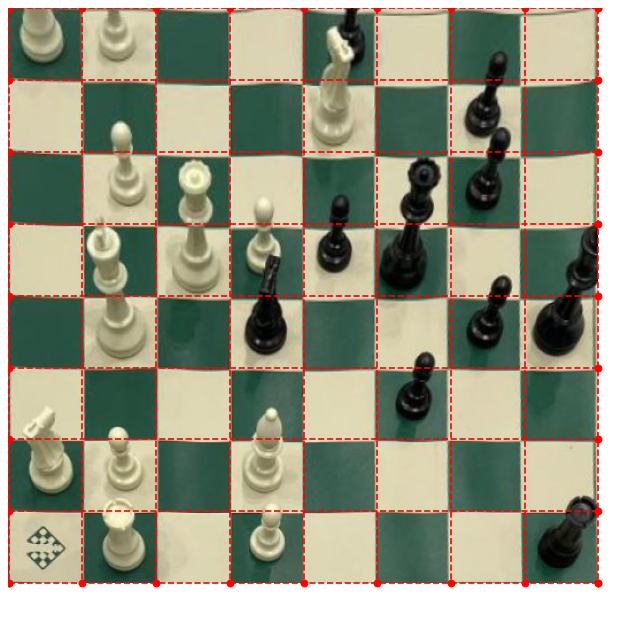

In [10]:
image = '1.jpg'

corners = detect_corners(image)

transformed_image = four_point_transform(image, corners)

ptsT, ptsL = plot_grid_on_transformed_image(transformed_image)



#calculate the grid

xA = ptsT[0][0]
xB = ptsT[1][0]
xC = ptsT[2][0]
xD = ptsT[3][0]
xE = ptsT[4][0]
xF = ptsT[5][0]
xG = ptsT[6][0]
xH = ptsT[7][0]
xI = ptsT[8][0]

y9 = ptsL[0][1]
y8 = ptsL[1][1] 
y7 = ptsL[2][1] 
y6 = ptsL[3][1]  
y5 = ptsL[4][1]  
y4 = ptsL[5][1] 
y3 = ptsL[6][1]  
y2 = ptsL[7][1] 
y1 = ptsL[8][1] 

#calculate all the squares

a8 = np.array([[xA,y9], [xB, y9], [xB, y8], [xA, y8]])
a7 = np.array([[xA,y8], [xB, y8], [xB, y7], [xA, y7]])
a6 = np.array([[xA,y7], [xB, y7], [xB, y6], [xA, y6]])
a5 = np.array([[xA,y6], [xB, y6], [xB, y5], [xA, y5]])
a4 = np.array([[xA,y5], [xB, y5], [xB, y4], [xA, y4]])
a3 = np.array([[xA,y4], [xB, y4], [xB, y3], [xA, y3]])
a2 = np.array([[xA,y3], [xB, y3], [xB, y2], [xA, y2]])
a1 = np.array([[xA,y2], [xB, y2], [xB, y1], [xA, y1]])

b8 = np.array([[xB,y9], [xC, y9], [xC, y8], [xB, y8]])
b7 = np.array([[xB,y8], [xC, y8], [xC, y7], [xB, y7]])
b6 = np.array([[xB,y7], [xC, y7], [xC, y6], [xB, y6]])
b5 = np.array([[xB,y6], [xC, y6], [xC, y5], [xB, y5]])
b4 = np.array([[xB,y5], [xC, y5], [xC, y4], [xB, y4]])
b3 = np.array([[xB,y4], [xC, y4], [xC, y3], [xB, y3]])
b2 = np.array([[xB,y3], [xC, y3], [xC, y2], [xB, y2]])
b1 = np.array([[xB,y2], [xC, y2], [xC, y1], [xB, y1]])

c8 = np.array([[xC,y9], [xD, y9], [xD, y8], [xC, y8]])
c7 = np.array([[xC,y8], [xD, y8], [xD, y7], [xC, y7]])
c6 = np.array([[xC,y7], [xD, y7], [xD, y6], [xC, y6]])
c5 = np.array([[xC,y6], [xD, y6], [xD, y5], [xC, y5]])
c4 = np.array([[xC,y5], [xD, y5], [xD, y4], [xC, y4]])
c3 = np.array([[xC,y4], [xD, y4], [xD, y3], [xC, y3]])
c2 = np.array([[xC,y3], [xD, y3], [xD, y2], [xC, y2]])
c1 = np.array([[xC,y2], [xD, y2], [xD, y1], [xC, y1]])

d8 = np.array([[xD,y9], [xE, y9], [xE, y8], [xD, y8]])
d7 = np.array([[xD,y8], [xE, y8], [xE, y7], [xD, y7]])
d6 = np.array([[xD,y7], [xE, y7], [xE, y6], [xD, y6]])
d5 = np.array([[xD,y6], [xE, y6], [xE, y5], [xD, y5]])
d4 = np.array([[xD,y5], [xE, y5], [xE, y4], [xD, y4]])
d3 = np.array([[xD,y4], [xE, y4], [xE, y3], [xD, y3]])
d2 = np.array([[xD,y3], [xE, y3], [xE, y2], [xD, y2]])
d1 = np.array([[xD,y2], [xE, y2], [xE, y1], [xD, y1]])

e8 = np.array([[xE,y9], [xF, y9], [xF, y8], [xE, y8]])
e7 = np.array([[xE,y8], [xF, y8], [xF, y7], [xE, y7]])
e6 = np.array([[xE,y7], [xF, y7], [xF, y6], [xE, y6]])
e5 = np.array([[xE,y6], [xF, y6], [xF, y5], [xE, y5]])
e4 = np.array([[xE,y5], [xF, y5], [xF, y4], [xE, y4]])
e3 = np.array([[xE,y4], [xF, y4], [xF, y3], [xE, y3]])
e2 = np.array([[xE,y3], [xF, y3], [xF, y2], [xE, y2]])
e1 = np.array([[xE,y2], [xF, y2], [xF, y1], [xE, y1]])

f8 = np.array([[xF,y9], [xG, y9], [xG, y8], [xF, y8]])
f7 = np.array([[xF,y8], [xG, y8], [xG, y7], [xF, y7]])
f6 = np.array([[xF,y7], [xG, y7], [xG, y6], [xF, y6]])
f5 = np.array([[xF,y6], [xG, y6], [xG, y5], [xF, y5]])
f4 = np.array([[xF,y5], [xG, y5], [xG, y4], [xF, y4]])
f3 = np.array([[xF,y4], [xG, y4], [xG, y3], [xF, y3]])
f2 = np.array([[xF,y3], [xG, y3], [xG, y2], [xF, y2]])
f1 = np.array([[xF,y2], [xG, y2], [xG, y1], [xF, y1]])

g8 = np.array([[xG,y9], [xH, y9], [xH, y8], [xG, y8]])
g7 = np.array([[xG,y8], [xH, y8], [xH, y7], [xG, y7]])
g6 = np.array([[xG,y7], [xH, y7], [xH, y6], [xG, y6]])
g5 = np.array([[xG,y6], [xH, y6], [xH, y5], [xG, y5]])
g4 = np.array([[xG,y5], [xH, y5], [xH, y4], [xG, y4]])
g3 = np.array([[xG,y4], [xH, y4], [xH, y3], [xG, y3]])
g2 = np.array([[xG,y3], [xH, y3], [xH, y2], [xG, y2]])
g1 = np.array([[xG,y2], [xH, y2], [xH, y1], [xG, y1]])

h8 = np.array([[xH,y9], [xI, y9], [xI, y8], [xH, y8]])
h7 = np.array([[xH,y8], [xI, y8], [xI, y7], [xH, y7]])
h6 = np.array([[xH,y7], [xI, y7], [xI, y6], [xH, y6]])
h5 = np.array([[xH,y6], [xI, y6], [xI, y5], [xH, y5]])
h4 = np.array([[xH,y5], [xI, y5], [xI, y4], [xH, y4]])
h3 = np.array([[xH,y4], [xI, y4], [xI, y3], [xH, y3]])
h2 = np.array([[xH,y3], [xI, y3], [xI, y2], [xH, y2]])
h1 = np.array([[xH,y2], [xI, y2], [xI, y1], [xH, y1]])

bottom_middle_points = detect_objects_and_get_bottom_middle(transformed_image)
squares = [a1, b1, c1, d1, e1, f1, g1, h1,a2, b2, c2, d2, e2, f2, g2, h2,a3, b3, c3, d3, e3, f3, g3, h3,a4, b4, c4, d4, e4, f4, g4, h4,a5, b5, c5, d5, e5, f5, g5, h5,a6, b6, c6, d6, e6, f6, g6, h6,a7, b7, c7, d7, e7, f7, g7, h7,a8, b8, c8, d8, e8, f8, g8, h8
]

fen_string = create_fen_from_detections(bottom_middle_points, squares)
print( fen_string)
print("http://www.ee.unb.ca/cgi-bin/tervo/fen.pl")
